In [31]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Kinetic Ising Model simulation
Ising model with $N$ spins $\{-1,1\}$, cuplings matrix $J_{ij}$ and external field $h_i$. 

At each time step $\delta t$ each spin $s_i$ flips with a probability 
$$p_{flip} = \gamma \delta t \frac 1 2 [1-s_i(t)\tanh H_i(t)] \quad with \quad
H_i = h_i + \sum_{j \ne i} J_{ij}s_j(t)$$

## Simulation

In [32]:
def simulation(J,h,gamma,steps,dt):
    S = [-np.ones(N)]
    for i in tqdm(range(steps)):
        s = np.copy(S[-1])
        H = h + np.dot(J,s)
        p_flip = gamma*dt*0.5*(1-s*np.tanh(H))
        p = np.random.rand(N)
        s[p<p_flip]*=-1
        S.append(s)
    S = np.array(S).T
    return S

In [33]:
np.random.seed(201098)

N = 10
#########################################
J = np.random.normal(0,1,(N,N))
np.fill_diagonal(J,0)
h = np.random.normal(0,1,N)

p_real = np.concatenate((J.flatten(),h))
##########################################
gamma = 1
steps = 1_000_000#1_000_000
dt = 0.1
##########################################
##SIMULATION
S = simulation(J,h,gamma,steps,dt)

100%|██████████| 1000000/1000000 [00:15<00:00, 63482.95it/s]


Text(0.5, 1.0, 'Spin evlolution in time. [$s_i=1$ yellow, $s_i=-1$ blue]')

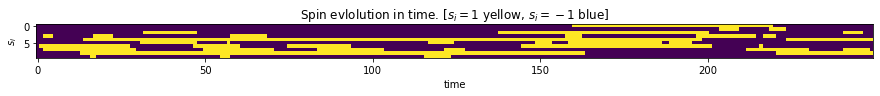

In [34]:
plt.figure(figsize=(15,10))
plt.imshow(S[:,:250])
plt.xlabel('time')
plt.ylabel(r'$s_i$')
plt.title(r'Spin evlolution in time. [$s_i=1$ yellow, $s_i=-1$ blue]')

### NB
$S$ is $S_{it}$ 

## Inference

### Equations

$$
\dot C_{ij} = \delta t ^{-1} \cdot [\langle s_i(t+\delta t)\cdot s_j(t) \rangle_{t} - C_{i,j}] \\
C_{ij} = \langle s_i(t)\cdot s_j(t) \rangle_{t} \\
L = \frac 1 {N_t} \sum_t\sum_i \Big[ h_i\cdot s_i(t) + \big[\sum_{j\ne i} J_{ij}\cdot (\gamma^{-1}\dot{C_{ij}} + C_{ij})\big] - \log \cosh H_i(t)\Big]
$$

### $C$ and $\dot C$

In [35]:
def C_and_Cdot(S,dt):
    # S row is the spins conf
    # S column is the single spin evolution
    N = S.shape[0]
    C = np.zeros((N,N))
    # since C is simmetric we can optimize it ... 
    for i in tqdm(range(N),desc='Computing C'):
        for j in range(N):
            C[i,j] = np.mean(S[i]*S[j])
        
    C_dot = np.zeros((N,N))
    for i in tqdm(range(N),desc='Computing C_dot'):
        for j in range(N):
            C_dot[i,j] = np.mean(S[i,1:]*S[j,:-1])
        
    C_dot -= C
    C_dot /= dt
        
    return C,C_dot        

In [36]:
C,C_dot = C_and_Cdot(S,dt)

Computing C_dot: 100%|██████████| 10/10 [00:00<00:00, 12.62it/s]


## L
In order to speed up the L function we use matrices.

$equations$

In [37]:
def logcosh(x):
    #the funcion is even, the trick is to avoid e^x
    x = np.abs(x)
    return np.log(1/2) + x + np.log(1 + np.exp(-2*x))

#versione ottimizzata della funzione (e' super piu veloce); sfrutta numpy e le matrici
def L(p,S,C,C_dot,gamma):
    N_t = S.shape[1]
    N = S.shape[0]
    
    # p are the params, S is the spins history
    J = p[:N*N].reshape((N,N))     # NxN matrix
    np.fill_diagonal(J,0)          #removing the diagonal terms for easier sums
    h = p[N*N:]                    # N vector
    
    #### A #####
    A = np.dot(S.T,h)
    A = np.mean(A)
    
    #### B #####
    B = J*(C_dot/gamma + C)
    B = np.sum(B)
    
    #### C #####
    C = np.tile(h,(N_t,1)).T
    C += np.dot(J,S)
    C = - logcosh(C)
    C = np.mean(np.sum(C,axis=0))
    
    L = A+B+C
    return L

In [38]:
#generating random parameters
np.random.seed(234)
p = np.random.normal(0,1,N*N+N)

In [39]:
L(p,S,C,C_dot,gamma)

-20.721406511708224

## Gradinent
$$
\frac {\partial L}{\partial h_i} = \langle s_i(t) - \tanh{H_i(t)} \rangle_t \\
\frac {\partial L}{\partial J_{ij}} = \gamma ^ {-1} \dot{C_{ij}} + C_{ij} - \langle \tanh{(H_i(t))}s_j(t)  \rangle_t
$$

Also in this case we use matrices to speed up the computation

In [93]:
def grad_L(p,S,C,C_dot,gamma):
    N_t = S.shape[1]
    N = S.shape[0]
    
    # p are the params, S is the spins history
    J = p[:N*N].reshape((N,N))     # NxN matrix
    np.fill_diagonal(J,0)          #removing the diagonal terms for easier sums
    h = p[N*N:]                    # N vector
    
    #grad wrt h
    H = (h + np.dot(J,S).T).T
    G_1 = np.mean(S-np.tanh(H),axis=1)
    
    #grad wrt J
    G_0 = C_dot/gamma + C
    G_0 -= (np.dot(np.tanh(H),S.T))/N_t
    return np.concatenate((G_0.flatten(),G_1))
    

## Test the gradient

In [94]:
param = 1

x = np.ones(N*N + N) + 10
dx = 0.00001
print(grad_L(x,S,C,C_dot,gamma)[param])
y_i = L(x,S,C,C_dot,gamma)
x[param]+=dx
y_f = L(x,S,C,C_dot,gamma)
print((y_f-y_i)/dx)

0.098171682108318
0.09817077852858345


### Maximization

### SGA

100%|██████████| 150/150 [02:44<00:00,  1.10s/it]

MSE:  20.097867827803405


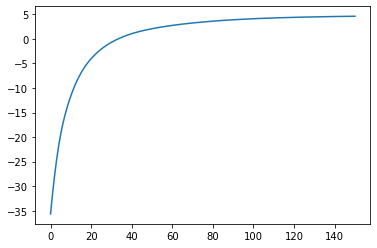

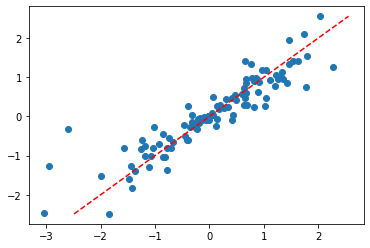

In [42]:
np.random.seed(1234)
l_r = 0.2
STEPS = 150
p_0 = np.random.normal(0,2,N*N+N)

ris = [L(p_0,S,C,C_dot,gamma)]
for i in tqdm(range(STEPS)):
    p_0 += l_r*grad_L(p_0,S,C,C_dot,gamma)
    ris.append(L(p_0,S,C,C_dot,gamma))
    if ris[-1]<ris[-2]: break

print('MSE: ',np.sum((p_0-p_real)**2))  
plt.plot(ris)
plt.figure()
plt.plot(p_0,p_real,'o')
plt.plot([min(p_real),max(p_real)],[min(p_real),max(p_real)],'--',color ='red')

### NAG

100%|██████████| 150/150 [02:53<00:00,  1.16s/it]

MSE:  8.671814172631478


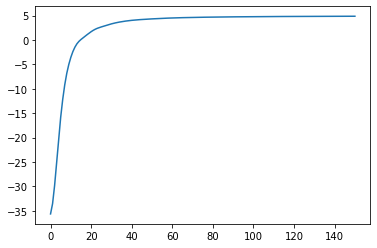

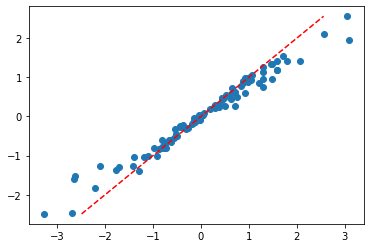

In [43]:
np.random.seed(1234)
p_nag = np.random.normal(0,2,N*N+N)
v = np.zeros(N*N+N)
### PARAMS
steps = 150
l_r = 0.1
fric = 0.9


ris = [L(p_nag,S,C,C_dot,gamma)]
for i in tqdm(range(steps)):
    v = fric*v + l_r * (grad_L(p_nag+fric*v,S,C,C_dot,gamma))
    p_nag += v
    ris.append(L(p_nag,S,C,C_dot,gamma))

print('MSE: ',np.sum((p_nag-p_real)**2))      
plt.plot(ris)
plt.figure()
plt.plot(p_nag,p_real,'o')
plt.plot([min(p_real),max(p_real)],[min(p_real),max(p_real)],'--',color ='red')

### RMS prop

100%|██████████| 200/200 [03:43<00:00,  1.12s/it]

MSE:  0.5455303932393318


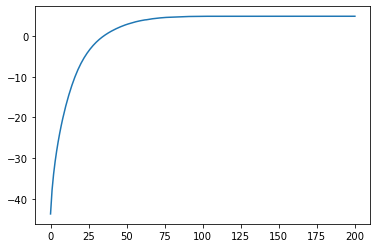

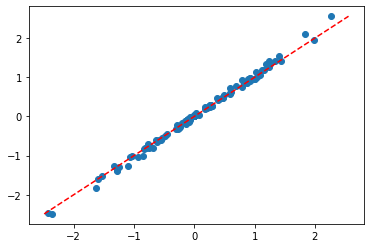

In [44]:
p_rms = np.random.normal(0,2,N*N+N)
s = np.zeros(N*N+N)
### PARAMS
steps = 200
l_r = 0.05
beta = 0.9
eps = 10**(-8)

ris = [L(p_rms,S,C,C_dot,gamma)]
for i in tqdm(range(steps)):
    g = grad_L(p_rms,S,C,C_dot,gamma)
    s = beta * s + (1-beta)*g*g
    p_rms += l_r*g/np.sqrt(s+eps)                                      
    
    ris.append(L(p_rms,S,C,C_dot,gamma))

print('MSE: ',np.sum((p_rms-p_real)**2))      
plt.plot(ris)
plt.figure()
plt.plot(p_rms,p_real,'o')
plt.plot([min(p_real),max(p_real)],[min(p_real),max(p_real)],'--',color ='red')

## ADAM

100%|██████████| 149/149 [01:37<00:00,  1.53it/s]

MSE:  0.8452692888463197


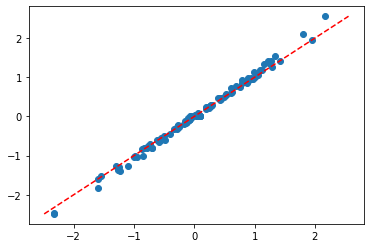

In [46]:
p_adam = np.random.normal(0,2,N*N+N)
s = np.zeros(N*N+N)
m = np.zeros(N*N+N)

s_h = np.zeros(N*N+N)
m_h = np.zeros(N*N+N)

### PARAMS
steps = 150
l_r = 0.1
beta1 = 0.9
beta2 = 0.9
eps = 10**(-8)

ris = [L(p_adam,S,C,C_dot,gamma)]
for i in tqdm(range(1,steps)):
    g = grad_L(p_adam,S,C,C_dot,gamma)
    m = beta1 * m + (1-beta1)*g
    s = beta2 * s + (1-beta2)*g*g
    m_h = 1/(1-beta1**i)*m
    s_h = 1/(1-beta2**i)*s
    
    p_adam += l_r*m_h/np.sqrt(s_h+eps)                                      
    #ris.append(L(p_adam,S,C,C_dot,gamma))

print('MSE: ',np.sum((p_adam-p_real)**2))  
#plt.plot(ris)
plt.figure()
plt.plot(p_adam,p_real,'o')
plt.plot([min(p_real),max(p_real)],[min(p_real),max(p_real)],'--',color ='red')

### IDEAS
by now the best optimizer is RMS, the ideas to speed up the compuing are :
- parallelize the optimization, how? IDK 
- use mini batch to optimize
- numba : doesn't support mean function so we have to rewrite everything from scratch (see below)

In [2]:
from numba import njit
import numpy as np
@njit
def n_mean(a):
    N = len(a)
    m = 0
    for i in (a):
        m=m+i
    return m/N

@njit
def n_sum(a,b):
    return a+b

@njit(parallel = True)
def n_sum2(a,b):
    N =len(a)
    c = np.zeros(N)
    for i in range(N):   
        c[i] = a[i] + b[i]
    return c

In [35]:
%timeit n_mean(np.ones(10000))
%timeit np.mean(np.ones(10000))

16.8 µs ± 91.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
20.9 µs ± 339 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [36]:
a = np.ones(100_000_000)
%timeit a+a
%timeit n_sum(a,a)
%timeit n_sum2(a,a)

185 ms ± 553 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
358 ms ± 3.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
305 ms ± 23.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
